## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

# had to change to tensorflow's keras implementation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import optimizers
from tensorflow.keras import initializers

import tensorflow.keras.backend as K

%matplotlib inline

## Data

In [2]:
rootdir = os.pardir
in_dir = os.path.join(rootdir, 'data/processed')

train_data = np.load(os.path.join(in_dir, 'train.npz'))
test_data = np.load(os.path.join(in_dir, 'test.npz'))

X_orig = train_data['X_train']
Y_orig = train_data['Y_train']
X_test_orig = test_data['X_test']
Y_test_orig = test_data['Y_test']

X_orig = X_orig.reshape(X_orig.shape[0], X_orig.shape[1],
                        X_orig.shape[2], 1)
X_test_orig = X_test_orig.reshape(X_test_orig.shape[0], X_test_orig.shape[1],
                        X_test_orig.shape[2], 1)

X_train_orig, X_dev_orig, Y_train_orig, Y_dev_orig = train_test_split(
    X_orig, Y_orig, test_size=0.20)

X_train = (X_train_orig - X_train_orig.mean()) / X_train_orig.std()
X_dev = (X_dev_orig - X_dev_orig.mean()) / X_dev_orig.std()

Y_train = Y_train_orig
Y_dev = Y_dev_orig

## Model

In [3]:
# only define one of the architectures
def get_CNN_1A(dropout_rate_conv, dropout_rate_dense):
    """
    The function defines the CNN_1A model
    
    Arguments:
    dropout_rate_conv -- hyperparameter controlling the dropout rate
        for conv layers
    dropout_rate_dense -- hyperparameter controlling the dropout rate
        for dense (fully connected) layers
    
    Returns:
    model -- keras model
    """
    model = Sequential()
    
    model.add(ZeroPadding2D(padding=(0, 1), input_shape=(11, 34, 1)))
    model.add(Conv2D(2, (1, 3), strides=(1, 1),
                     activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(1, 3))) # last column being dropped
    model.add(Dropout(dropout_rate_conv))
    
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(2, (3, 3), strides=(2, 2),
                    activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(dropout_rate_dense))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [10]:
def get_optimizer(learning_rate):
    optimizer = optimizers.Adam(lr=learning_rate) # could use lr decay
    return optimizer

In [4]:
def plot_losses(losses):
    fig = plt.figure()
    ax = plt.axes()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    plt.plot(np.arange(1, len(losses)+1), losses)
    return None

In [5]:
def train_model(hyperparameters, custom_metrics, X_train, Y_train, X_dev, Y_dev):
    
    # get hparams
    learning_rate = hyperparameters['lr']
    dropout_conv_rate = hyperparameters['dropout_conv']
    dropout_dense_rate = hyperparameters['dropout_dense']
    n_epochs = hyperparameters['epochs']
    get_model = hyperparameters['architecture'][1]

    # build model
    model = get_model(dropout_conv_rate, dropout_dense_rate)
    optimizer = get_optimizer(learning_rate)
    model.compile(optimizer=optimizer,
                 metrics=custom_metrics,
                 loss='binary_crossentropy')
    
    # train model
    history = model.fit(X_train, Y_train, batch_size=128, epochs=n_epochs,
              validation_data=(X_dev, Y_dev))
    
    # plot losses
    plot_losses(history.history['loss'])

    return model, history

In [6]:
# metrics need to be defined according to Keras' standards
# using the backend (tensorflow) tensor operations
def precision(y_true, y_pred):
    """Precision metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (total_positives + K.epsilon())
    return recall


def f1_score(y_true, y_pred):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    """
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1_score = 2 * (p * r) / (p + r + K.epsilon())
    return f1_score

In [7]:
custom_metrics = ['accuracy', precision, recall, f1_score] # which one to use to evaluate model? accuracy or f1-score?

In [9]:
hyperparameters = dict()

## Training the model for ALS classification

In [ ]:
Y_train_als = redefine_labels(Y_train, 1)
Y_dev_als = redefine_labels(Y_dev, 1)

In [ ]:
hyperparameters['architecture'] = get_CNN_1A
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_als, X_dev, Y_dev_als)

***

**The model is predicting every case as non ALS!!!!**

This happens with each one of the 4 networks, regardless of dropout or learning rate. What is wrong?

**Things to try:**
1. Bigger networks
    * More filters
    * More layers
2. Different normalization of input data: divide by range instead of standardizing

***

#### A) Check weights

In [55]:
weights = model.get_weights()

In [78]:
len(weights)

8

In [69]:
W1 = weights[0]
print(W1.shape)
print(W1.max())
print(W1.min())
print(W1.mean())

(1, 3, 1, 2)
0.78827554
-0.8649973
0.158396


In [70]:
b1 = weights[1]
print(b1.shape)
print(b1.max())
print(b1.min())
print(b1.mean())

(2,)
0.09654459
0.004111087
0.05032784


In [71]:
W2 = weights[2]
print(W2.shape)
print(W2.max())
print(W2.min())
print(W2.mean())

(3, 3, 2, 2)
0.40975013
-0.37487692
-0.023815565


In [72]:
b2 = weights[3]
print(b2.shape)
print(b2.max())
print(b2.min())
print(b2.mean())

(2,)
0.07860064
-0.06817381
0.0052134134


In [74]:
W3 = weights[4]
print(W3.shape)
print(W3.max())
print(W3.min())
print(W3.mean())

(8, 12)
0.64280665
-0.5723054
-0.02318577


In [75]:
b3 = weights[5]
print(b3.shape)
print(b3.max())
print(b3.min())
print(b3.mean())

(12,)
0.12630284
-0.07719131
0.010404105


In [76]:
W4 = weights[6]
print(W4.shape)
print(W4.max())
print(W4.min())
print(W4.mean())

(12, 1)
0.3771407
-0.6453672
-0.099824555


In [77]:
b4 = weights[7]
print(b4.shape)
print(b4.max())
print(b4.min())
print(b4.mean())

(1,)
-0.06772911
-0.06772911
-0.06772911


In [79]:
model_ALS_1A_1 = model
history_ALS_1A_1 = history
# save it just in case

#### B) Try different normalization

In [81]:
# range
spread_train = (X_train_orig.max() - X_train_orig.min())
spread_dev = (X_dev_orig.max() - X_dev_orig.min())
print('Range in train set: {0}'.format(spread_train))
print('Range in dev set: {0}'.format(spread_dev))

Range in train set: 2357.88922942707
Range in dev set: 713.6219252276783


In [82]:
X_train = X_train_orig / spread_train
X_dev =  X_dev_orig / spread_dev

Train on 833 samples, validate on 209 samples
Epoch 1/200
833/833 [==============================] - 1s 642us/step - loss: 4.4986 - acc: 0.1897 - precision: 0.1897 - recall: 1.0000 - f1_score: 0.3165 - val_loss: 4.7307 - val_acc: 0.1435 - val_precision: 0.1435 - val_recall: 1.0000 - val_f1_score: 0.2507
Epoch 2/200
833/833 [==============================] - 0s 29us/step - loss: 4.4496 - acc: 0.1897 - precision: 0.1897 - recall: 1.0000 - f1_score: 0.3177 - val_loss: 4.6768 - val_acc: 0.1435 - val_precision: 0.1435 - val_recall: 1.0000 - val_f1_score: 0.2507
Epoch 3/200
833/833 [==============================] - 0s 36us/step - loss: 4.3987 - acc: 0.1897 - precision: 0.1897 - recall: 1.0000 - f1_score: 0.3172 - val_loss: 4.6227 - val_acc: 0.1435 - val_precision: 0.1435 - val_recall: 1.0000 - val_f1_score: 0.2507
Epoch 4/200
833/833 [==============================] - 0s 34us/step - loss: 4.3478 - acc: 0.1897 - precision: 0.1897 - recall: 1.0000 - f1_score: 0.3166 - val_loss: 4.5690 - val_a

Epoch 64/200
833/833 [==============================] - 0s 29us/step - loss: 2.1575 - acc: 0.1897 - precision: 0.1897 - recall: 1.0000 - f1_score: 0.3174 - val_loss: 2.2523 - val_acc: 0.1435 - val_precision: 0.1435 - val_recall: 1.0000 - val_f1_score: 0.2507
Epoch 65/200
833/833 [==============================] - 0s 29us/step - loss: 2.1325 - acc: 0.1897 - precision: 0.1897 - recall: 1.0000 - f1_score: 0.3174 - val_loss: 2.2256 - val_acc: 0.1435 - val_precision: 0.1435 - val_recall: 1.0000 - val_f1_score: 0.2507
Epoch 66/200
833/833 [==============================] - 0s 30us/step - loss: 2.1077 - acc: 0.1897 - precision: 0.1897 - recall: 1.0000 - f1_score: 0.3176 - val_loss: 2.1994 - val_acc: 0.1435 - val_precision: 0.1435 - val_recall: 1.0000 - val_f1_score: 0.2507
Epoch 67/200
833/833 [==============================] - 0s 29us/step - loss: 2.0831 - acc: 0.1897 - precision: 0.1897 - recall: 1.0000 - f1_score: 0.3178 - val_loss: 2.1735 - val_acc: 0.1435 - val_precision: 0.1435 - val_re

Epoch 96/200
833/833 [==============================] - 0s 29us/step - loss: 1.4926 - acc: 0.1897 - precision: 0.1897 - recall: 1.0000 - f1_score: 0.3176 - val_loss: 1.5485 - val_acc: 0.1435 - val_precision: 0.1435 - val_recall: 1.0000 - val_f1_score: 0.2507
Epoch 97/200
833/833 [==============================] - 0s 29us/step - loss: 1.4763 - acc: 0.1897 - precision: 0.1897 - recall: 1.0000 - f1_score: 0.3181 - val_loss: 1.5312 - val_acc: 0.1435 - val_precision: 0.1435 - val_recall: 1.0000 - val_f1_score: 0.2507
Epoch 98/200
833/833 [==============================] - 0s 27us/step - loss: 1.4602 - acc: 0.1897 - precision: 0.1897 - recall: 1.0000 - f1_score: 0.3163 - val_loss: 1.5140 - val_acc: 0.1435 - val_precision: 0.1435 - val_recall: 1.0000 - val_f1_score: 0.2507
Epoch 99/200
833/833 [==============================] - 0s 29us/step - loss: 1.4440 - acc: 0.1897 - precision: 0.1897 - recall: 1.0000 - f1_score: 0.3178 - val_loss: 1.4974 - val_acc: 0.1435 - val_precision: 0.1435 - val_re

833/833 [==============================] - 0s 31us/step - loss: 0.8704 - acc: 0.1969 - precision: 0.1849 - recall: 0.9496 - f1_score: 0.3080 - val_loss: 0.8882 - val_acc: 0.1196 - val_precision: 0.1187 - val_recall: 0.7919 - val_f1_score: 0.2063
Epoch 159/200
833/833 [==============================] - 0s 31us/step - loss: 0.8651 - acc: 0.1969 - precision: 0.1850 - recall: 0.9537 - f1_score: 0.3082 - val_loss: 0.8824 - val_acc: 0.1196 - val_precision: 0.1149 - val_recall: 0.7612 - val_f1_score: 0.1994
Epoch 160/200
833/833 [==============================] - 0s 29us/step - loss: 0.8598 - acc: 0.1981 - precision: 0.1844 - recall: 0.9476 - f1_score: 0.3069 - val_loss: 0.8768 - val_acc: 0.1196 - val_precision: 0.1149 - val_recall: 0.7612 - val_f1_score: 0.1994
Epoch 161/200
833/833 [==============================] - 0s 30us/step - loss: 0.8546 - acc: 0.2005 - precision: 0.1843 - recall: 0.9349 - f1_score: 0.3070 - val_loss: 0.8713 - val_acc: 0.1244 - val_precision: 0.1156 - val_recall: 0.76

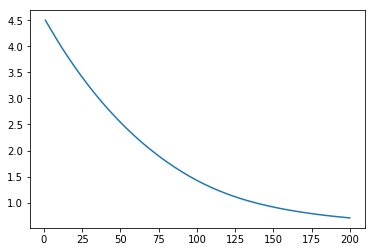

In [43]:
hyperparameters['architecture'] = get_CNN_1A
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_als, X_dev, Y_dev_als)

#### C) Try with bigger NN

In [95]:
# go back to original normalization
X_train = (X_train_orig - X_train_orig.mean()) / X_train_orig.std()
X_dev = (X_dev_orig - X_dev_orig.mean()) / X_dev_orig.std()

Train on 833 samples, validate on 209 samples
Epoch 1/200
833/833 [==============================] - 1s 791us/step - loss: 0.6839 - acc: 0.7251 - precision: 0.4164 - recall: 0.7007 - f1_score: 0.4942 - val_loss: 0.6711 - val_acc: 0.8373 - val_precision: 0.3742 - val_recall: 0.2225 - val_f1_score: 0.2696
Epoch 2/200
833/833 [==============================] - 0s 32us/step - loss: 0.6634 - acc: 0.8079 - precision: 0.2878 - recall: 0.0638 - f1_score: 0.0996 - val_loss: 0.6470 - val_acc: 0.8612 - val_precision: 0.6124 - val_recall: 0.0306 - val_f1_score: 0.0583
Epoch 3/200
833/833 [==============================] - 0s 32us/step - loss: 0.6437 - acc: 0.8103 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6237 - val_acc: 0.8565 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/200
833/833 [==============================] - 0s 38us/step - loss: 0.6244 - acc: 0.8103 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0

Epoch 30/200
833/833 [==============================] - 0s 29us/step - loss: 0.4431 - acc: 0.8103 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.3939 - val_acc: 0.8565 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 31/200
833/833 [==============================] - 0s 29us/step - loss: 0.4404 - acc: 0.8103 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.3925 - val_acc: 0.8565 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 32/200
833/833 [==============================] - 0s 29us/step - loss: 0.4377 - acc: 0.8103 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.3909 - val_acc: 0.8565 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 33/200
833/833 [==============================] - 0s 30us/step - loss: 0.4350 - acc: 0.8103 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_sco

Epoch 92/200
833/833 [==============================] - 0s 31us/step - loss: 0.3303 - acc: 0.8535 - precision: 0.6772 - recall: 0.4000 - f1_score: 0.4967 - val_loss: 0.3383 - val_acc: 0.8517 - val_precision: 0.4796 - val_recall: 0.2919 - val_f1_score: 0.3557
Epoch 93/200
833/833 [==============================] - 0s 30us/step - loss: 0.3299 - acc: 0.8535 - precision: 0.6978 - recall: 0.4278 - f1_score: 0.5253 - val_loss: 0.3381 - val_acc: 0.8517 - val_precision: 0.4796 - val_recall: 0.2919 - val_f1_score: 0.3557
Epoch 94/200
833/833 [==============================] - 0s 31us/step - loss: 0.3295 - acc: 0.8535 - precision: 0.6850 - recall: 0.4163 - f1_score: 0.5162 - val_loss: 0.3379 - val_acc: 0.8517 - val_precision: 0.4796 - val_recall: 0.2919 - val_f1_score: 0.3557
Epoch 95/200
833/833 [==============================] - 0s 29us/step - loss: 0.3291 - acc: 0.8535 - precision: 0.6690 - recall: 0.4190 - f1_score: 0.5076 - val_loss: 0.3379 - val_acc: 0.8517 - val_precision: 0.4796 - val_re

833/833 [==============================] - 0s 28us/step - loss: 0.3092 - acc: 0.8499 - precision: 0.6566 - recall: 0.4360 - f1_score: 0.5166 - val_loss: 0.3149 - val_acc: 0.8469 - val_precision: 0.4408 - val_recall: 0.2919 - val_f1_score: 0.3483
Epoch 155/200
833/833 [==============================] - 0s 30us/step - loss: 0.3087 - acc: 0.8499 - precision: 0.6473 - recall: 0.4295 - f1_score: 0.5130 - val_loss: 0.3151 - val_acc: 0.8469 - val_precision: 0.4408 - val_recall: 0.2919 - val_f1_score: 0.3483
Epoch 156/200
833/833 [==============================] - 0s 29us/step - loss: 0.3083 - acc: 0.8499 - precision: 0.6501 - recall: 0.4272 - f1_score: 0.5058 - val_loss: 0.3163 - val_acc: 0.8469 - val_precision: 0.4408 - val_recall: 0.2919 - val_f1_score: 0.3483
Epoch 157/200
833/833 [==============================] - 0s 29us/step - loss: 0.3082 - acc: 0.8511 - precision: 0.6656 - recall: 0.4459 - f1_score: 0.5314 - val_loss: 0.3171 - val_acc: 0.8517 - val_precision: 0.4612 - val_recall: 0.32

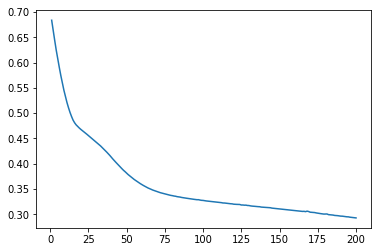

In [46]:
hyperparameters['architecture'] = get_CNN_1C
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_als, X_dev, Y_dev_als)

**A bigger network seems to improve the new metrics, even without tuning any parameter**

In [ ]:
def compare_models(disease):
    in_dir = os.path.join(rootdir, 'trained_models')
    
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    plt.grid()

    for filename in os.listdir(in_dir):
        if filename.startswith(disease) and filename.endswith('pickle'):
            with open(os.path.join(in_dir, filename), 'rb') as handle:
                history = pickle.load(handle)
            ax.plot(history['val_loss'], label=filename[:7])

    ax.legend()
    
    return None